In [ ]:
import tensorflow as tf
import numpy as np
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "6"
import matplotlib.pyplot as plt
%matplotlib inline
tf.test.is_gpu_available()

True

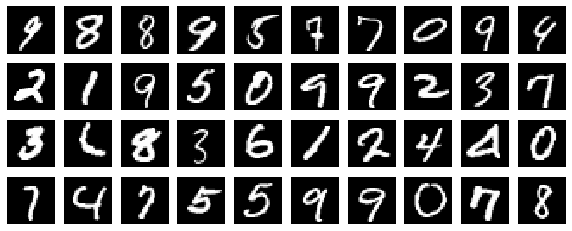

In [ ]:
################### hyper parameter ##############################
lr=5e-5
img_dim = 28  
channel = 1
batch_size = 64
z_dim = 128

#################### get dataset ##################################

(x_train,y_train),(x_test,y_test)=tf.keras.datasets.mnist.load_data()

def preprocess(images):
    images = tf.expand_dims(images, axis=-1)
    images = tf.image.resize(images, (img_dim, img_dim))
    images = (tf.cast(images, dtype=tf.float32)-127.5)/127.5
    return images
ds = tf.data.Dataset.from_tensor_slices((x_train))
ds = ds.map(preprocess).shuffle(100000).batch(batch_size,drop_remainder=True)


for sample_images in ds.take(1):
    break

################### plot function ##################################
%matplotlib inline
def plot_image(x, n_row=3, n_col=10):
    if x.shape[-1] == 1:
        x = x[:,:,:,0]
    x = ((x+1)*127.5).numpy().astype(np.uint8)
    plt.figure(figsize=(n_col, n_row))
    for i in range(1,n_row+1):
        for j in range(1,n_col+1):
            index = (i-1)*n_col + j
            plt.subplot(n_row,n_col,index)
            plt.imshow(x[index-1], cmap='gray')
            plt.axis("off")
    plt.show()
plot_image(sample_images, n_row=4, n_col=10) 

In [ ]:
def G_Resblock(inputs, nums_out):
    temp = tf.identity(inputs)
    x = tf.keras.layers.BatchNormalization()(inputs)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.UpSampling2D()(x)
    x = tf.keras.layers.Conv2D(filters=nums_out,
               kernel_size=3,
               strides=1,padding="same")(x)

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(filters=nums_out,
               kernel_size=3,
               strides=1,padding="same")(x)
    #Identity mapping
    temp = tf.keras.layers.UpSampling2D()(temp)
    temp = tf.keras.layers.Conv2D(filters=nums_out,
               kernel_size=1,
               strides=1,padding="same")(temp)
    return x + temp
def create_generator_model():
    z_in = tf.keras.layers.Input(shape=(z_dim, ))
    inputs = tf.keras.layers.Dense(256*7*7)(z_in)
    inputs = tf.keras.layers.Reshape([7, 7, 256])(inputs)
    inputs = G_Resblock(inputs, 256)
    inputs = G_Resblock(inputs, 256)
    inputs = tf.keras.layers.BatchNormalization()(inputs)
    inputs = tf.keras.layers.Activation('relu')(inputs)
    inputs = tf.keras.layers.Conv2D(channel, 3, strides=1, padding="same")(inputs)
    inputs = tf.keras.layers.Activation('tanh')(inputs)
    generator = tf.keras.Model(z_in, inputs)
    return generator
generator = create_generator_model()
generator.summary()
sample_z = tf.random.uniform((batch_size,z_dim),minval=-1,maxval=1)
generator(sample_z).shape

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 12544)        1618176     input_5[0][0]                    
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 7, 7, 256)    0           dense_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_10 (BatchNo (None, 7, 7, 256)    1024        reshape_2[0][0]                  
____________________________________________________________________________________________

TensorShape([64, 28, 28, 1])

In [ ]:
class SpectralNormalization(tf.keras.layers.Wrapper):
    def __init__(self, layer, iteration=1, eps=1e-12, training=True, **kwargs):
        self.iteration = iteration
        self.eps = eps
        self.do_power_iteration = training
        if not isinstance(layer, tf.keras.layers.Layer):
            raise ValueError(
                'Please initialize `TimeDistributed` layer with a '
                '`Layer` instance. You passed: {input}'.format(input=layer))
        super(SpectralNormalization, self).__init__(layer, **kwargs)

    def build(self, input_shape):
        self.layer.build(input_shape)

        self.w = self.layer.kernel
        self.w_shape = self.w.shape.as_list()

        self.v = self.add_weight(shape=(1, self.w_shape[0] * self.w_shape[1] * self.w_shape[2]),
                                 initializer=tf.initializers.TruncatedNormal(stddev=0.02),
                                 trainable=False,
                                 name='sn_v',
                                 dtype=tf.float32)

        self.u = self.add_weight(shape=(1, self.w_shape[-1]),
                                 initializer=tf.initializers.TruncatedNormal(stddev=0.02),
                                 trainable=False,
                                 name='sn_u',
                                 dtype=tf.float32)
 
        super(SpectralNormalization, self).build()

    def call(self, inputs):
        self.update_weights()
        output = self.layer(inputs)
        self.restore_weights()  # Restore weights because of this formula "W = W - alpha * W_SN`"
        return output
    
    def update_weights(self):
        w_reshaped = tf.reshape(self.w, [-1, self.w_shape[-1]])
        
        u_hat = self.u
        v_hat = self.v  # init v vector

        if self.do_power_iteration:
            for _ in range(self.iteration):
                v_ = tf.matmul(u_hat, tf.transpose(w_reshaped))
                v_hat = v_ / (tf.reduce_sum(v_**2)**0.5 + self.eps)

                u_ = tf.matmul(v_hat, w_reshaped)
                u_hat = u_ / (tf.reduce_sum(u_**2)**0.5 + self.eps)

        sigma = tf.matmul(tf.matmul(v_hat, w_reshaped), tf.transpose(u_hat))
        self.u.assign(u_hat)
        self.v.assign(v_hat)

        self.layer.kernel.assign(self.w / sigma)

    def restore_weights(self):
        self.layer.kernel.assign(self.w)

def D_Resblock(inputs, nums_out, is_down=True,is_sn=False):
    temp = tf.identity(inputs)
    inputs =  tf.keras.layers.Activation('relu')(inputs)
    
    if is_sn:
        inputs = SpectralNormalization(tf.keras.layers.Conv2D(nums_out, 3, 1,padding="same"))(inputs)
    else:
        inputs = tf.keras.layers.Conv2D(nums_out, 3, 1,padding="same")(inputs)
    inputs = tf.keras.layers.Activation('relu')(inputs)
    
    if is_sn:
        inputs = SpectralNormalization(tf.keras.layers.Conv2D(nums_out, 3, 1,padding="same"))(inputs)
    else:
        inputs = tf.keras.layers.Conv2D(nums_out, 3, 1,padding="same")(inputs)
        
    if is_down:
        inputs = tf.keras.layers.AveragePooling2D()(inputs)
        #Identity mapping
        if is_sn:
            temp = SpectralNormalization(tf.keras.layers.Conv2D(nums_out, 1, 1,padding="same"))(temp)
        else:
            temp = tf.keras.layers.Conv2D(nums_out, 1, 1,padding="same")(temp)
        temp = tf.keras.layers.AveragePooling2D()(temp)
    else:
#         temp = conv("identity", temp, nums_out, 1, 1, update_collection, is_sn=True)
        if is_sn:
            temp = SpectralNormalization(tf.keras.layers.Conv2D(nums_out, 1, 1,padding="same"))(temp)
        else:
            temp = tf.keras.layers.Conv2D(nums_out, 1, 1,padding="same")(temp)
    return inputs + temp

def D_FirstResblock(inputs, nums_out, is_down=True, is_sn=False):
    temp = tf.identity(inputs)
    if is_sn:
        inputs = SpectralNormalization(tf.keras.layers.Conv2D(nums_out, 3, 1,padding="same"))(inputs)
    else:
        inputs = tf.keras.layers.Conv2D(nums_out, 3, 1,padding="same")(inputs)
    inputs = tf.keras.layers.Activation('relu')(inputs)
    if is_sn:
        inputs = SpectralNormalization(tf.keras.layers.Conv2D(nums_out, 3, 1,padding="same"))(inputs)
    else:
        inputs = tf.keras.layers.Conv2D(nums_out, 3, 1,padding="same")(inputs)
    if is_down:
        inputs = tf.keras.layers.AveragePooling2D()(inputs)
        #Identity mapping
        temp = tf.keras.layers.AveragePooling2D()(temp)
        if is_sn:
            temp = SpectralNormalization(tf.keras.layers.Conv2D(nums_out, 1, 1,padding="same"))(temp)
        else:
            temp = tf.keras.layers.Conv2D(nums_out, 1, 1,padding="same")(temp)
    return inputs + temp
def create_discriminator_model():
    x_in = tf.keras.layers.Input(shape=(img_dim, img_dim, channel)) 
    inputs = D_FirstResblock(x_in, 128, is_down=True,is_sn=False) #do not use spectral normalization
    inputs = D_Resblock(inputs,128,is_down=True,is_sn=False)
    inputs = D_Resblock(inputs,128, is_down=False,is_sn=False)
    inputs = tf.keras.layers.Activation('relu')(inputs)
    inputs = tf.keras.layers.Flatten()(inputs) 
    inputs = tf.keras.layers.Dense(z_dim)(inputs) 
    discriminator = tf.keras.Model(x_in, inputs)
    return discriminator
discriminator = create_discriminator_model()
discriminator.summary()
discriminator(sample_images).shape

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 28, 28, 128)  1280        input_6[0][0]                    
__________________________________________________________________________________________________
activation_30 (Activation)      (None, 28, 28, 128)  0           conv2d_39[0][0]                  
__________________________________________________________________________________________________
tf_op_layer_Identity_12 (Tensor [(None, 28, 28, 1)]  0           input_6[0][0]                    
____________________________________________________________________________________________

TensorShape([64, 128])

# CKGAN using linear combination of characteristic kernels

In [ ]:
class LearnedKernel(tf.keras.Model):

  def __init__(self, is_use_softmax = True, is_use_one_hot = False):
    super(LearnedKernel,self).__init__()
    self.is_use_softmax = is_use_softmax
    self.is_use_one_hot = is_use_one_hot
    self.kernel_function = [self.gaussian_kernel, self.rbf_kernel, self.laplacian_kernel, 
                 self.exponential_kernel, self.martern_3_2_kernel, self.martern_5_2_kernel]
    self.variable_one = tf.ones((len(self.kernel_function,)))

  def build(self, input_shape):
    self.kernel_weight = self.add_weight("kernel_weight", shape=[len(self.kernel_function)])

  def call(self, x, y):
    kernel_weight = self.kernel_weight
    if self.is_use_softmax:
      kernel_weight = tf.nn.softmax(tf.multiply(self.kernel_weight, self.variable_one))

      if self.is_use_one_hot:
        # generae one_hot vector
        masked_one_hot = tf.one_hot(tf.argmax(kernel_weight), len(self.kernel_function))
        kernel_weight = tf.multiply(kernel_weight, masked_one_hot)

    # print("kernel_weight", kernel_weight)
    output = 0
    for i in range(len(self.kernel_function)):
      output += kernel_weight[i] * self.kernel_function[i](x,y)
    return output

  def gaussian_kernel(self, a,b, sigma=10):
    return tf.exp(-tf.divide(tf.norm(a-b,axis=-1)**2, 2*sigma**2))
  def rbf_kernel(self, a,b, K=5):
    sum = 0
    sigma_q = 0.5
    for k in range(K):
      sigma_q *= 2
      sum += self.gaussian_kernel(a,b,sigma_q)
    return sum
  def laplacian_kernel(self, a,b, sigma=100):
    return tf.exp(-tf.divide(tf.norm(a-b, ord=1, axis=-1), sigma))
  def exponential_kernel(self, a,b,sigma=10):
    return tf.exp(-tf.divide(tf.norm(a-b, axis=-1), sigma))
  def martern_3_2_kernel(self, a,b,alpha=1,l=10):
    sqrt_3 = tf.sqrt(3.)
    def r_function(a,b):
      return tf.norm(a-b, axis=-1)/l
    r = r_function(a,b)
    return alpha*(1+sqrt_3*r)*tf.exp(-sqrt_3*r)
  def martern_5_2_kernel(self, a,b,alpha=1,l=10):
    sqrt_5 = tf.sqrt(5.)
    def r_function(a,b):
      return tf.norm(a-b, axis=-1)/l
    r = r_function(a,b)
    return alpha*(1+sqrt_5*r+(5./3.)*r**2)*tf.exp(-sqrt_5*r)

learned_kernel = LearnedKernel(is_use_softmax = True, is_use_one_hot = False)
learned_kernel(sample_z,sample_z).shape

TensorShape([64])

In [ ]:
generator_optimizer = tf.optimizers.RMSprop(lr,0.99)
discriminator_optimizer = tf.optimizers.RMSprop(lr,0.99)

#========================== kernel function ==========================
def gaussian_kernel(a,b, sigma=10):
  return tf.exp(-tf.divide(tf.norm(a-b,axis=-1)**2, 2*sigma**2))
def rbf_kernel(a,b, K=5):
  k = 0
  sigma_q = 0.5
  for k in range(K):
    k += gaussian_kernel(a,b,sigma_q)
    sigma_q *= 2
  return k
def laplacian_kernel(a,b, sigma=100):
  return tf.exp(-tf.divide(tf.norm(a-b, ord=1, axis=-1), sigma))
def exponential_kernel(a,b,sigma=10):
  return tf.exp(-tf.divide(tf.norm(a-b, axis=-1), sigma))
def martern_3_2_kernel(a,b,alpha=1,l=10):
  sqrt_3 = tf.sqrt(3.)
  def r_function(a,b):
    return tf.norm(a-b, axis=-1)/l
  r = r_function(a,b)
  return alpha*(1+sqrt_3*r)*tf.exp(-sqrt_3*r)
def martern_5_2_kernel(a,b,alpha=1,l=10):
  sqrt_5 = tf.sqrt(5.)
  def r_function(a,b):
    return tf.norm(a-b, axis=-1)/l
  r = r_function(a,b)
  return alpha*(1+sqrt_5*r+(5./3.)*r**2)*tf.exp(-sqrt_5*r)


def gradient_penalty(real_data, generated_data):
  alpha = tf.random.uniform((batch_size,1,1,1),minval=0,maxval=1,dtype=tf.float32)
  
  interpolated = alpha * real_data + (1 - alpha) * generated_data
  with tf.GradientTape() as tape:
    tape.watch(interpolated)
    prob_interpolated = discriminator(interpolated)
  gradients = tape.gradient(prob_interpolated,interpolated)

  gradients = tf.reshape(gradients,(batch_size,-1))
  gradients_norm = tf.sqrt(tf.reduce_sum(gradients ** 2, axis=1))
  # Return gradient penalty
  return 10*tf.reduce_mean((gradients_norm) ** 2)
#========================== define train step ==========================

@tf.function
def train(real_images, k=learned_kernel, _lambda=1.0):
    
    # train discrimnator
    for i in range(5):
        with tf.GradientTape() as discriminator_tape:
          z = tf.random.uniform((batch_size, z_dim), minval=-1.0, maxval=1.0)
          x = generator(z)
          x_fake = discriminator(x)
          discriminator_loss = -k(z,discriminator(real_images)) + k(x_fake,z) + gradient_penalty(real_images,x)
          discriminator_loss = tf.reduce_mean(discriminator_loss)
        trainable_variables = discriminator.trainable_variables + learned_kernel.trainable_variables
        discriminator_grads = discriminator_tape.gradient(discriminator_loss, trainable_variables)
        discriminator_optimizer.apply_gradients(zip(discriminator_grads, trainable_variables))

    # train generator
    with tf.GradientTape() as generator_tape:
        z  = tf.random.uniform((batch_size, z_dim),minval=-1.0, maxval=1.0)
        x_fake = discriminator(generator(z))
        generator_loss = tf.reduce_mean(-k(x_fake,z))
    trainable_variables = generator.trainable_variables + learned_kernel.trainable_variables
    generator_grads = generator_tape.gradient(generator_loss, trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_grads, trainable_variables))
    return generator_loss,discriminator_loss

train(sample_images)

(<tf.Tensor: shape=(), dtype=float32, numpy=-0.90916616>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.33765692>)

epoch: 0 i: 0 generator_loss: -0.9109616 discriminator_loss: 0.20822565
epoch: 0 i: 100 generator_loss: -0.5372535 discriminator_loss: -0.07641107
epoch: 0 i: 200 generator_loss: -0.6261995 discriminator_loss: -0.13195121
epoch: 0 i: 300 generator_loss: -0.21096897 discriminator_loss: -0.12292972
epoch: 0 i: 400 generator_loss: -0.7234635 discriminator_loss: -0.09818555
epoch: 0 i: 500 generator_loss: -0.33709192 discriminator_loss: -0.16947538
epoch: 0 i: 600 generator_loss: -0.5929157 discriminator_loss: -0.13353567
epoch: 0 i: 700 generator_loss: -0.35390264 discriminator_loss: -0.1450674
epoch: 0 i: 800 generator_loss: -0.76011246 discriminator_loss: -0.0901577
epoch: 0 i: 900 generator_loss: -0.4861911 discriminator_loss: -0.12553898
epoch: 0


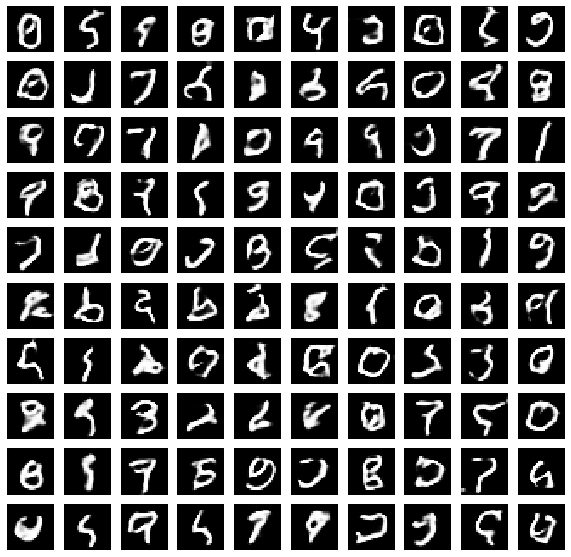

epoch: 1 i: 0 generator_loss: -0.6824882 discriminator_loss: -0.1425963


KeyboardInterrupt: 

In [ ]:
epochs = 100
save_epoch = 5
for epoch in range(epochs):
    for i,real_images in enumerate(iter(ds)):
        generator_loss,discriminator_loss = train(real_images)
        
        if i%100 == 0:
            print("epoch:",epoch,"i:",i, 
                  "generator_loss:",generator_loss.numpy(), 
                 "discriminator_loss:", discriminator_loss.numpy(), 
                  )

    if epoch % 40 == 0:    
      print("epoch:",epoch)  
      n_row,n_col = 10,10 
      sample_z = tf.random.uniform((n_row*n_col,z_dim),minval=-1.0, maxval=1.0)
      sample_fake_image = generator(sample_z)
      plot_image(sample_fake_image, n_row=n_row, n_col=n_row)


# CKGAN using single characteristic kernel

In [ ]:
generator_optimizer = tf.optimizers.RMSprop(lr,0.99)
discriminator_optimizer = tf.optimizers.RMSprop(lr,0.99)

#========================== kernel function ==========================
def gaussian_kernel(a,b, sigma=10):
  return tf.exp(-tf.divide(tf.norm(a-b,axis=-1)**2, 2*sigma**2))
def rbf_kernel(a,b, K=5):
  k = 0
  sigma_q = 0.5
  for k in range(K):
    k += gaussian_kernel(a,b,sigma_q)
    sigma_q *= 2
  return k
def laplacian_kernel(a,b, sigma=100):
  return tf.exp(-tf.divide(tf.norm(a-b, ord=1, axis=-1), sigma))
def exponential_kernel(a,b,sigma=10):
  return tf.exp(-tf.divide(tf.norm(a-b, axis=-1), sigma))
def martern_3_2_kernel(a,b,alpha=1,l=10):
  sqrt_3 = tf.sqrt(3.)
  def r_function(a,b):
    return tf.norm(a-b, axis=-1)/l
  r = r_function(a,b)
  return alpha*(1+sqrt_3*r)*tf.exp(-sqrt_3*r)
def martern_5_2_kernel(a,b,alpha=1,l=10):
  sqrt_5 = tf.sqrt(5.)
  def r_function(a,b):
    return tf.norm(a-b, axis=-1)/l
  r = r_function(a,b)
  return alpha*(1+sqrt_5*r+(5./3.)*r**2)*tf.exp(-sqrt_5*r)

def gradient_penalty(real_data, generated_data):
  alpha = tf.random.uniform((batch_size,1,1,1),minval=0,maxval=1,dtype=tf.float32)
  
  interpolated = alpha * real_data + (1 - alpha) * generated_data
  with tf.GradientTape() as tape:
    tape.watch(interpolated)
    prob_interpolated = discriminator(interpolated)
  gradients = tape.gradient(prob_interpolated,interpolated)

  gradients = tf.reshape(gradients,(batch_size,-1))
  gradients_norm = tf.sqrt(tf.reduce_sum(gradients ** 2, axis=1))
  # Return gradient penalty
  return 10*tf.reduce_mean((gradients_norm - 1) ** 2)

#========================== define train step ==========================
@tf.function
def train(real_images, k=gaussian_kernel, _lambda=1.0):
    
    # train discrimnator
    for i in range(5):
        with tf.GradientTape() as discriminator_tape:
          z = tf.random.uniform((batch_size, z_dim), minval=-1.0, maxval=1.0)
          x = generator(z)
          x_fake = discriminator(x)
          discriminator_loss = -k(z,discriminator(real_images)) + k(x_fake,z) + gradient_penalty(real_images,x)
          discriminator_loss = tf.reduce_mean(discriminator_loss)
        discriminator_grads = discriminator_tape.gradient(discriminator_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(discriminator_grads, discriminator.trainable_variables))

    # train generator
    with tf.GradientTape() as generator_tape:
        z  = tf.random.uniform((batch_size, z_dim),minval=-1.0, maxval=1.0)
        x_fake = discriminator(generator(z))
        generator_loss = tf.reduce_mean(-k(x_fake,z)) 
    generator_grads = generator_tape.gradient(generator_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_grads, generator.trainable_variables))
    return generator_loss,discriminator_loss

train(sample_images)

(<tf.Tensor: shape=(), dtype=float32, numpy=-0.80927366>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.052297663>)

epoch: 0 i: 0 generator_loss: -0.804765 discriminator_loss: 0.01486212
epoch: 0 i: 100 generator_loss: -0.49923688 discriminator_loss: -0.03762973
epoch: 0 i: 200 generator_loss: -0.37158164 discriminator_loss: -0.12631695
epoch: 0 i: 300 generator_loss: -0.7659143 discriminator_loss: -0.0027397852
epoch: 0 i: 400 generator_loss: -0.48665413 discriminator_loss: -0.09555011
epoch: 0 i: 500 generator_loss: -0.13542071 discriminator_loss: -0.14210108
epoch: 0 i: 600 generator_loss: -0.77781236 discriminator_loss: 0.022221267
epoch: 0 i: 700 generator_loss: -0.5675333 discriminator_loss: -0.13290223
epoch: 0 i: 800 generator_loss: -0.5795499 discriminator_loss: 0.00644397
epoch: 0 i: 900 generator_loss: -0.45986944 discriminator_loss: -0.04730213
epoch: 0


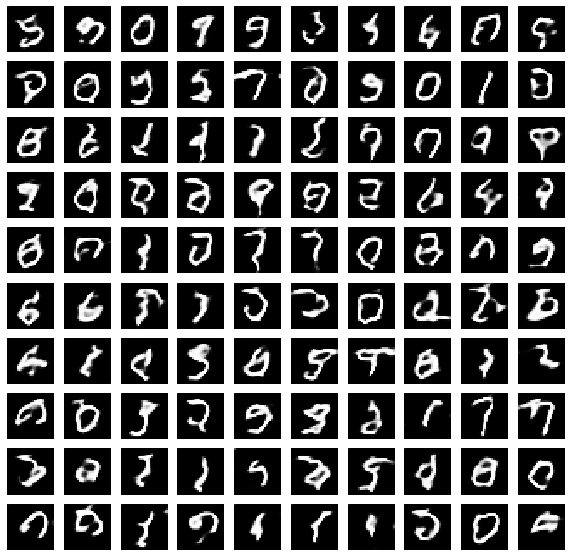

epoch: 1 i: 0 generator_loss: -0.35364956 discriminator_loss: -0.052524272


KeyboardInterrupt: 

In [ ]:
epochs = 100
save_epoch = 5
for epoch in range(epochs):
    for i,real_images in enumerate(iter(ds)):
        generator_loss,discriminator_loss = train(real_images)
        
        if i%100 == 0:
            print("epoch:",epoch,"i:",i, 
                  "generator_loss:",generator_loss.numpy(), 
                 "discriminator_loss:", discriminator_loss.numpy(), 
                  )

    if epoch % 40 == 0:    
      print("epoch:",epoch)  
      n_row,n_col = 10,10 
      sample_z = tf.random.uniform((n_row*n_col,z_dim),minval=-1.0, maxval=1.0)
      sample_fake_image = generator(sample_z)
      plot_image(sample_fake_image, n_row=n_row, n_col=n_row)


# compute FID

In [ ]:
# !pip install StealthFlow
from stealthflow.fid import FIDNumpy

total_num=10000

def build_IS_images(total_num = 10000):
    total_images = []
    for i in range(int(np.ceil(total_num/batch_size))):
        sample_z = tf.random.uniform((batch_size,z_dim),minval=-1.0, maxval=1.0)
        sample_fake_image = generator(sample_z)
        images = ((sample_fake_image+1)*127.5).numpy().astype(np.uint8)
        total_images.append(images)
    total_images = np.array(total_images)
    total_images = np.concatenate([np.squeeze(array) for array in np.split(total_images,total_images.shape[0])])
    return total_images[:total_num]

def build_IS_images_from_datasets(total_num = 1000):
    total_images = []
    for images in ds.take(np.ceil(total_num/batch_size)):
        images = ((images+1)*127.5).numpy().astype(np.uint8)
        total_images.append(images)
    total_images = np.array(total_images)
    total_images = np.concatenate([np.squeeze(array) for array in np.split(total_images,total_images.shape[0])])
    return total_images[:total_num]


real_images = build_IS_images_from_datasets(total_num)
real_images = real_images.astype(np.float32).reshape(-1, img_dim, img_dim, channel)/255.0


generated_images = build_IS_images(total_num=total_num).astype(np.float32).reshape(-1, img_dim, img_dim, channel)/255.0
fid = FIDNumpy(batch_size=300, scaling=True)(generated_images, real_images)
print("generated images fid score:", fid)

Numpy mode
calculating features...(numpy), batch:1/33


KeyboardInterrupt: 

# compute IS

In [ ]:
# calculate inception score for cifar-10 in Keras
from math import floor
from numpy import ones
from numpy import expand_dims
from numpy import log
from numpy import mean
from numpy import std
from numpy import exp
from numpy.random import shuffle
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
# from tensorflow.keras.datasets import cifar10
from skimage.transform import resize
from numpy import asarray
import tensorflow as tf
import tqdm
import numpy as np
total_num = 20000


# scale an array of images to a new size
def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return asarray(images_list)

# assumes images have any shape and pixels in [0,255]
def calculate_inception_score(images, n_split=10, eps=1E-16):
	# load inception v3 model
	model = InceptionV3()
	# enumerate splits of images/predictions
	scores = list()
	n_part = floor(images.shape[0] / n_split)
	for i in range(n_split):
		# retrieve images
		ix_start, ix_end = i * n_part, (i+1) * n_part
		subset = images[ix_start:ix_end]
		# convert from uint8 to float32
		subset = subset.astype('float32')
		# scale images to the required size
		subset = scale_images(subset, (299,299,3))
		# pre-process images, scale to [-1,1]
		subset = preprocess_input(subset)
		# predict p(y|x)
		p_yx = model.predict(subset)
		# calculate p(y)
		p_y = expand_dims(p_yx.mean(axis=0), 0)
		# calculate KL divergence using log probabilities
		kl_d = p_yx * (log(p_yx + eps) - log(p_y + eps))
		# sum over classes
		sum_kl_d = kl_d.sum(axis=1)
		# average over images
		avg_kl_d = mean(sum_kl_d)
		# undo the log
		is_score = exp(avg_kl_d)
		# store
		scores.append(is_score)
	# average across images
	is_avg, is_std = mean(scores), std(scores)
	return is_avg, is_std

def build_IS_images(total_num = 10000):
    total_images = []
    for i in range(int(np.ceil(total_num/batch_size))):
        sample_z = tf.random.uniform((batch_size,z_dim), minval=-1, maxval=1)
        sample_fake_image = generator(sample_z)
        images = ((sample_fake_image+1)*127.5).numpy().astype(np.uint8)
        total_images.append(images)
    total_images = np.array(total_images)
    total_images = np.concatenate([np.squeeze(array) for array in np.split(total_images,total_images.shape[0])])
    return total_images[:total_num]
def build_IS_images_from_datasets(total_num = 1000):
    total_images = []
    for images in ds.take(np.ceil(total_num/batch_size)):
        images = ((images+1)*127.5).numpy().astype(np.uint8)
        total_images.append(images)
    total_images = np.array(total_images)
    total_images = np.concatenate([np.squeeze(array) for array in np.split(total_images,total_images.shape[0])])
    return total_images[:total_num]



images = build_IS_images(total_num=total_num)
print(images.shape)
is_avg, is_std = calculate_inception_score(images,n_split=5)
inception_score.append(is_avg)
inception_score_std.append(is_std)
print("generated images IS score ","mean:",is_avg,"std:",is_std,"epoch:",epoch)

(20000, 28, 28)


KeyboardInterrupt: 